In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
!pip install tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Function to test independence of 2 random variables. 

Usage: 

`testStat, thresh = hsic_gam(X, Y, alph = 0.05)`

Independence test result
- If testStat < thresh, x and y are independent.
- If testStat > thresh, x and y are not independent.


In [3]:
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12
Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).
Shoubo (shoubo.sub AT gmail.com)
https://github.com/amber0309/HSIC
09/11/2016
Inputs:
X n by dim_x matrix
Y n by dim_y matrix
alph level of test
Outputs:
testStat test statistics
thresh test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
    size1 = pattern1.shape
    size2 = pattern2.shape
    G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)
    Q = np.tile(G, (1, size2[0]))
    R = np.tile(H.T, (size1[0], 1))
    H = Q + R - 2* np.dot(pattern1, pattern2.T)
    H = np.exp(-H/2/(deg**2))
    return H


def hsic_gam(X, Y, alph = 0.5):
    """
    X, Y are numpy vectors with row - sample, col - dim
    alph is the significance level
    auto choose median to be the kernel width
    """
    n = X.shape[0]
    # ----- width of X -----
    Xmed = X
    G = np.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Xmed, Xmed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    # ----- width of X -----
    Ymed = Y
    G = np.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Ymed, Ymed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    bone = np.ones((n, 1), dtype = float)
    H = np.identity(n) - np.ones((n,n), dtype = float) / n
    K = rbf_dot(X, X, width_x)
    L = rbf_dot(Y, Y, width_y)
    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)
    testStat = np.sum(Kc.T * Lc) / n
    varHSIC = (Kc * Lc / 6)**2
    varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)
    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)
    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L)) 
    muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
    muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)
    mHSIC = (1 + muX * muY - muX - muY) / n
    al = mHSIC**2 / varHSIC
    bet = varHSIC*n / mHSIC
    thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]
    return (testStat, thresh)

# Linear model $Y=bX+\epsilon$

## Gaussian distribution

Generate data

In [4]:
N = 1000
#x = np.random.normal(0, 1, size=N)
x = np.random.uniform(0, 1, size=N)
#x = np.random.laplace(loc=0.0, scale=1., size=N)
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)
y = x + eps

Regress $Y$ on $X$

Text(0, 0.5, 'Y_residuals')

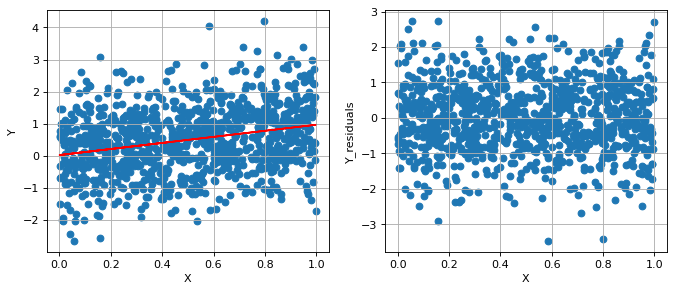

In [5]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x.reshape(-1, 1),y)
y_pred = regressor.predict(x.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")

Test independence

In [6]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.12828219267235788 0.6174123593570608
Independent: True


Regress $X$ on $Y$

Text(0, 0.5, 'X_residuals')

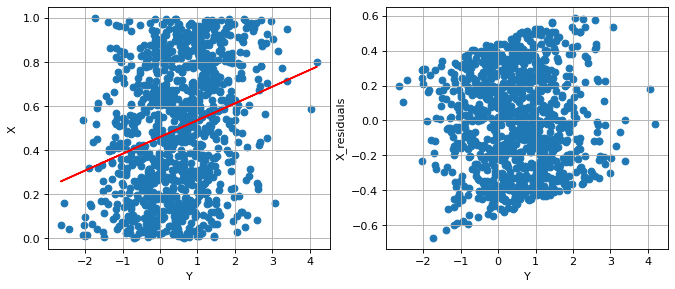

In [7]:
# build regression model
regressor.fit(y.reshape(-1, 1),x)
x_pred = regressor.predict(y.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
plt.plot(y, x_pred, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")

Test independence

In [8]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

1.3425114596755823 0.6108496113485079
Independent: False


$\newcommand{\indep}{\perp \!\!\! \perp}$
 $(X,\varepsilon)  \not\indep $
In order to determine cause and effect from $X$ and $Y$, regression on both directions are applied.
1. regressing $Y$ on $X$: 
$Y = X + \varepsilon$
2. regressing $X$ on $Y$:
$X = Y + \varepsilon$

Structure of the model in case (2) requires that predictor and noise would be independent, i.e., $Y \indep \varepsilon$, but we see from the plot above this condition doesn't hold, therefore model (2) is not valid and hence the direction is according to case (1): $X → Y$


## Exercise 1:
Try different distributions for $X$ and $\epsilon$ and fill the results in a table. What are your conclusions? Which cases are identifiable?

Note, you can use one type of distibution for $X$ and another type of distribution for $\epsilon$.

Distributions to use:
1. `np.random.normal`
2. `np.random.uniform`
3. `np.random.laplace`

## Example of non-linear model $Y=bX^3+\epsilon$

Generate data

In [9]:
N = 1000
x = np.sort(np.random.normal(0, 1, size=N)) # sort X
#x = np.sort(np.random.uniform(-3, 3, size=N))
#x = np.sort(np.random.laplace(loc=0.0, scale=1., size=N))
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)

y = x**3 + eps

Regress $Y$ on $X$

Text(0, 0.5, 'Y_residuals')

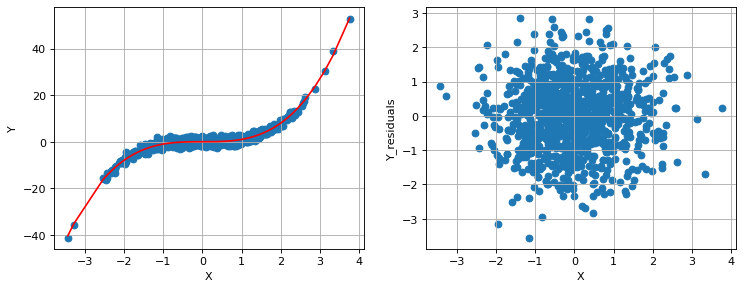

In [10]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# transform X to use LinearRegression model
x_transform = x**3
regressor.fit(x_transform.reshape(-1, 1),y)
y_pred = regressor.predict(x_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
#plt.scatter(x=x, y=y_pred, color="red")
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
#plt.xlabel("Y")
#plt.ylabel("X_residuals")

Test independence

In [11]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.3470571491479392 0.5826747990185741
Independent: True


Text(0, 0.5, 'X_residuals')

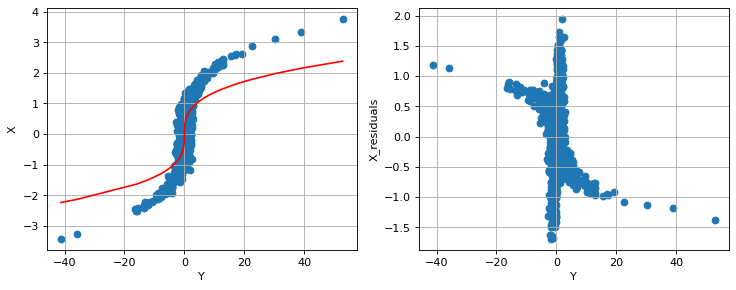

In [12]:
# build regression model
y_transform = np.cbrt(y)
regressor.fit(y_transform.reshape(-1, 1),x)
x_pred = regressor.predict(y_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
# sort by y 
y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
y_sorted = list(y_sorted)
x_pred_sorted = list(x_pred_sorted)

plt.plot(y_sorted, x_pred_sorted, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
#plt.xlabel("X")
#plt.ylabel("Y_residuals")

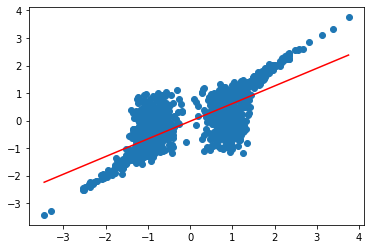

In [13]:
plt.scatter(y_transform, x)
plt.plot(y_transform, x_pred, color="red")

## Exercise 2

1. Try different distributions for $X$ and $\epsilon$ as in the previous assignment. Is there any case when we cannot identify causal direction?

## Exercise 3

1. Perform similar tests for the model  $Y=f(X)+\epsilon$, where the corresponding function $f(X)$ is specified [here](https://docs.google.com/spreadsheets/d/1aS87yTukUsMIJcLMMaeuVKnzVLkhhU7m3wKfNyN2I6E/edit?usp=sharing). 
Adjust the variation of $X$ and $\epsilon$ if required.
2. For varying values of variance ranging from $var(X) / var(\epsilon) = 0.01$ to $var(X) / var(\epsilon) = 100$, estimate the accuracy of direction identification as a fraction of correct identifications in 30 independent runs. Plot the results. For which ranges we observe identifiability?

### My Solution

In the following, I answer exercises 2 and 3 both at the same time in the procedure I follow.

First we define a `regress` function based on the following arguments:

x_mean: mean of distribution of $X$

x_var: variance of distribution of $X$

eps_mean: mean of distribution of $\varepsilon$

eps_var: variance of distribution of $\varepsilon$

x_dist: distribution used for $X$

eps_dist: distribution used for $\varepsilon$

`regress` gets an input string which determines which function to use in the addivite noise model. The choices are ("c","q","s") which correspond to cubic, quadratic, and sinus, respectively.
In the function I define two regressors, called `regressor1` and `regressor2`. The former is used to regress $Y$ on $X$, and the latter is used to regress $X$ on $Y$. The output and prediction of both are returned in order to be plotted, go through dependence test, and be compared later.




#### 2, 3.1

In [14]:
## 
def regress(x_mean, x_var, eps_mean, eps_var, size, x_dist, eps_dist, func="l", regressor=None):
    x = x_dist(x_mean, x_var, size=size)
    eps = eps_dist(eps_mean, eps_var, size=size)
    x_transformed = x.copy()
    # cubic function
    if func == "c":
        x_transformed = x**3
    # quadratic function
    elif func == "q":
        x_transformed = x**2
    # sinus functions    
    elif func == "s":
        x_transformed == np.sin(x)
    # regress on either x (in linear case, as x remains intact), or if nonlinear on transformed x

    y = x_transformed + eps
    regressor = LinearRegression()
    regressor.fit(x_transformed.reshape(-1, 1),y)
    y_pred = regressor.predict(x_transformed.reshape(-1, 1))

    #testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)

    y_transformed = y.copy()
    # cubic function
    if func == "c":
        y_transformed = y**3
    # quadratic function
    elif func == "q":
        y_transformed = y**2
    # sinus functions    
    elif func == "s":
        y_transformed == np.sin(y)


    regressor2 = LinearRegression()
    regressor2.fit(y_transformed.reshape(-1, 1), x)
    x_pred = regressor2.predict(y_transformed.reshape(-1, 1))
    #testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
    return x, x_transformed, eps, y, y_transformed, y_pred, x_pred

To test different distributions, I create a dictionary in which the keys are strings consisting three parts (the first and second parts are connected by `"_"`, and the second and third parts are connected by `"x"`). First part (before `"_"`) is the function used as additivie noise model, the second part (before `"x"`) is the name of distribution used for $X$, and the third part is the name of distribution used for $\varepsilon$. 
If there is no third part, then the distribution used for $X$ and $\varepsilon$ are both the same.
 The values of the dictionary applying `regress` function I defined above on the distributions determined in the key of dictionary.

Explaining some cases:

`"LIN_GAU"`: Use Gaussian as distirubtion of $X$ and $\varepsilon$, and the function is linear.

`"CUBIC_GAUxLAP"`: Use Gaussian as distribution of $X$, and use Laplace as distribution of $\varepsilon$, and the function is cubic.

`"QUAD_UNIxGAU"`: Use Uniform as distribution of $X$, and use Gaussian as distribution of $\varepsilon$, and the function is quadratic.


In order to answer 3.2 as well, in each value of the dictionary, I multiply the variance by `i`. For now I let it be 1. Later I let it vary between [0.01, 100] but only for choices (for distributions and the additive noise function) that showed identifiability with variance 1, so that I see if changing variance change their state of identifiability.




In [15]:
i=1
mean = 0
var = 1
size = (1000, 1)
regressor=None
normal = np.random.normal
uniform = np.random.uniform
laplace = np.random.laplace

regress_dict = {
    "LIN_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="l", regressor=regressor),
    "LIN_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="l", regressor=regressor),
    "LIN_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="l", regressor=regressor),
    "CUBIC_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="c", regressor=regressor),
    "CUBIC_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="c", regressor=regressor),
    "CUBIC_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="c", regressor=regressor),
    "QUAD_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="q", regressor=regressor),
    "QUAD_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="q", regressor=regressor),
    "QUAD_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="q", regressor=regressor),
    "SIN_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="s", regressor=regressor),
    "SIN_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="s", regressor=regressor),
    "SIN_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="s", regressor=regressor),

    "LIN_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="l", regressor=regressor),
    "LIN_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="l", regressor=regressor),
    "CUBIC_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="c", regressor=regressor),
    "CUBIC_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="c", regressor=regressor),
    "QUAD_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="q", regressor=regressor),
    "QUAD_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="q", regressor=regressor),
    "SIN_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="s", regressor=regressor),
    "SIN_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="s", regressor=regressor),


    "LIN_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="l", regressor=regressor),
    "LIN_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="l", regressor=regressor),
    "CUBIC_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="c", regressor=regressor),
    "CUBIC_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="c", regressor=regressor),
    "QUAD_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="q", regressor=regressor),
    "QUAD_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="q", regressor=regressor),
    "SIN_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="s", regressor=regressor),
    "SIN_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="s", regressor=regressor),


    "LIN_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="l", regressor=regressor),
    "LIN_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="l", regressor=regressor),
    "CUBIC_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="c", regressor=regressor),
    "CUBIC_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="c", regressor=regressor),
    "QUAD_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="q", regressor=regressor),
    "QUAD_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="q", regressor=regressor),
    "SIN_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="s", regressor=regressor),
    "SIN_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="s", regressor=regressor)
}


In [16]:
len(regress_dict['LIN_GAU'])

7

In [17]:
func_dists = list(regress_dict.keys())
func_dists[:10]

['LIN_GAU',
 'LIN_UNI',
 'LIN_LAP',
 'CUBIC_GAU',
 'CUBIC_UNI',
 'CUBIC_LAP',
 'QUAD_GAU',
 'QUAD_UNI',
 'QUAD_LAP',
 'SIN_GAU']

Now I define two functions: `reg_plotter` and `reg_dep`.
The former plots both regressions of $Y$ on $X$ and $X$ on $Y$, and then plots all the possible combinations defined above in the `regress_dict` dictionary.
The latter performs independence test between `x` and `y_residuals` for `regressor1`(this varialbe in inside `regress` function) and between `y` and `x_residuals` for `regressors2` (again, this is inside `regresse` function).

Using these both functions, I report plots and dependence test for all the combinations insdie `reg_dict` iteratively, and I store results that can determine cause and effect. For plots I had to eyeball them as identifiability detection can't be automated using them, but for dependence test, I could store results of dependence between noises and elements of the two regressions.





In [18]:
def reg_plotter(func_dist):
    func = func_dist
    if func_dist.startswith("CUBIC"):
      func = "Cubic"
    elif func_dist.startswith("QUAD"):
      func = "Quadratic"
    elif func_dist.startswith("SIN"):
      func = "Sinus"  
    elif func_dist.startswith("LIN"):
      func = "Linear"

    dist = func_dist.split("_")[1]

    if "x" in dist:
      x_dist = dist.split("x")[0]
      xd = x_dist
      eps_dist = dist.split("x")[1]
      ed = eps_dist      
    else:
        x_dist = dist
        xd = x_dist
        eps_dist = dist
        ed = eps_dist 
    if x_dist.startswith("GAU"):
      xd = "Gaussian"
    elif x_dist.startswith("LAP"):
      xd = "Laplace"  
    elif x_dist.startswith("UNI"):
      xd = "Uniform"   

    if eps_dist.startswith("GAU"):
      ed = "Gaussian"
    elif eps_dist.startswith("LAP"):
      ed = "Laplace"  
    elif eps_dist.startswith("UNI"):
      ed = "Uniform"   


    print(f"Distribution: (X,Epsilon) ~ {xd, ed}") 
    print(f"Function: {func}")  
    x, x_transformed, eps, y, y_transformed, y_pred, x_pred = regress_dict[func_dist] 
    
    # plotting
    figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.scatter(x=x, y=y)
    #plt.scatter(x=x, y=y_pred, color="red")
    plt.plot(x, y_pred, color="red")
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")

    # calculate the residuals and plot them
    y_residuals = y_pred - y
    plt.subplot(122)
    plt.scatter(x=x, y=y_residuals)
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y_residuals")
    #plt.xlabel("Y")
    #plt.ylabel("X_residuals")

    
    # plotting
    figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.scatter(x=y, y=x)
    # sort by y 
    y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
    y_sorted = list(y_sorted)
    x_pred_sorted = list(x_pred_sorted)

    plt.plot(y_sorted, x_pred_sorted, color="red")
    plt.grid(True)
    plt.xlabel("Y")
    plt.ylabel("X")

    # calculate the residuals and plot them
    x_residuals = x_pred - x
    plt.subplot(122)
    plt.scatter(x=y, y=x_residuals)
    plt.grid(True)
    plt.xlabel("Y")
    plt.ylabel("X_residuals")
    plt.show()
    print("\n")
    #plt.xlabel("X")
    #plt.ylabel("Y_residuals")





In [19]:
def reg_dep(func_dist):
    x, x_transformed, eps, y, y_transformed, y_pred, x_pred = regress_dict[func_dist] 
    y_residuals = y_pred - y	
    testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
    print(testStat, thresh)
    print("X, Eps are Independent: {}".format(testStat < thresh))
    x_residuals = x_pred - x
    testStat2, thresh2 = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
    print(testStat2, thresh2)
    print("Y, Eps are Independent: {}".format(testStat2 < thresh2))	
    return(testStat < thresh, testStat2 < thresh2)

Distribution: (X,Epsilon) ~ ('Gaussian', 'Gaussian')
Function: Linear


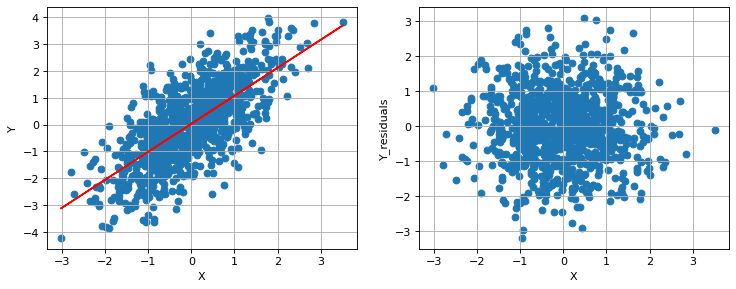

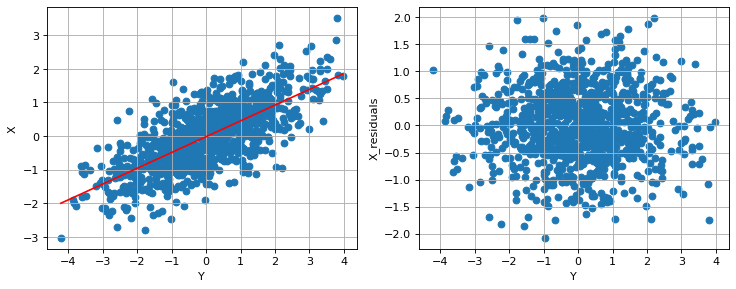



0.3111492362066663 0.583767772230895
X, Eps are Independent: True
0.22238107698619172 0.577810612095694
Y, Eps are Independent: True







Distribution: (X,Epsilon) ~ ('Uniform', 'Uniform')
Function: Linear


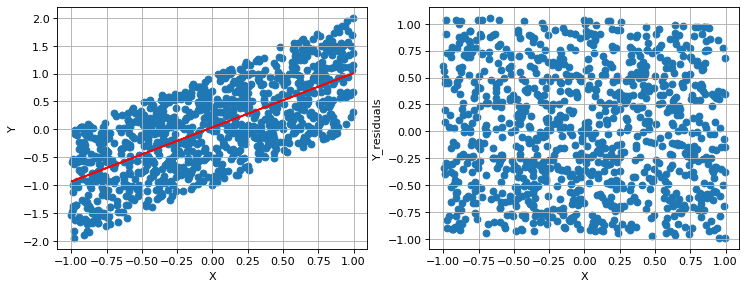

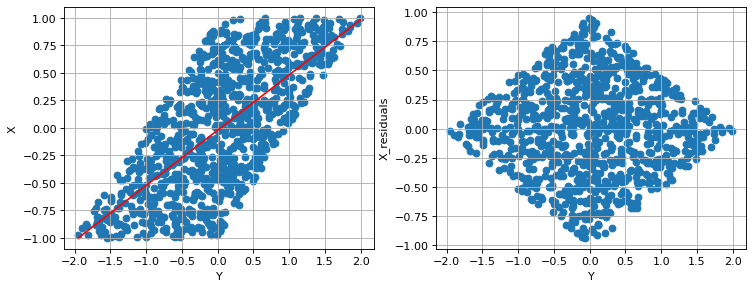



0.29850872182285915 0.649639306641402
X, Eps are Independent: True
6.804660288805802 0.5907162670300761
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Laplace')
Function: Linear


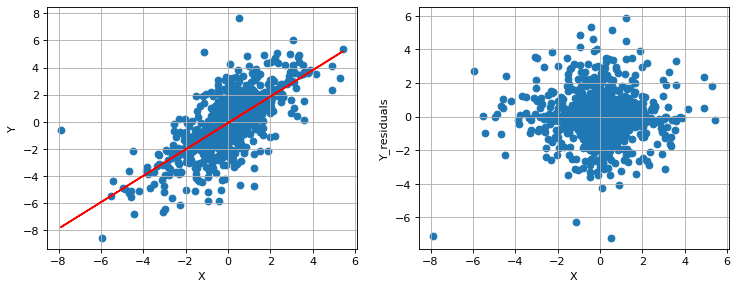

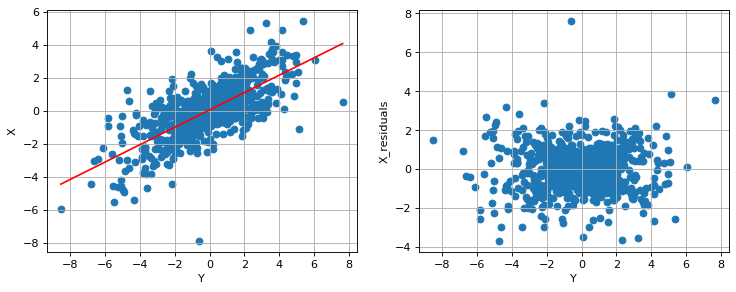



0.25862597002060395 0.5276116183479346
X, Eps are Independent: True
5.837330966221507 0.5739169864861079
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Gaussian')
Function: Cubic


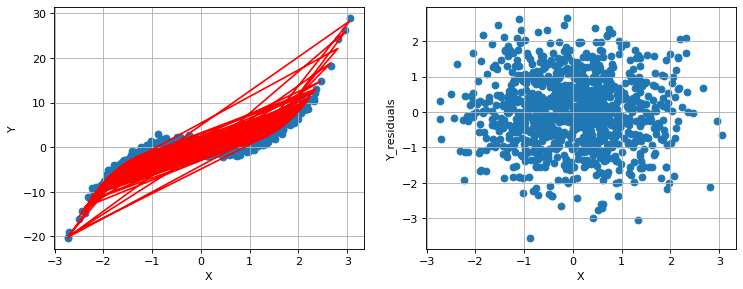

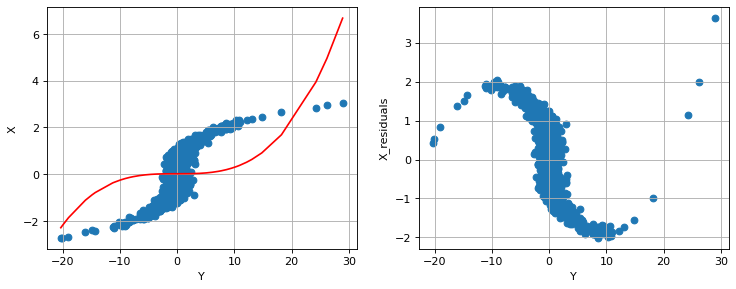



0.2912075958714947 0.586047652225979
X, Eps are Independent: True
29.284329568502276 0.6540348299882712
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Uniform')
Function: Cubic


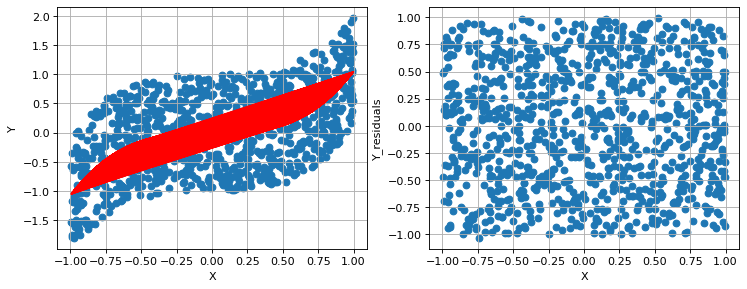

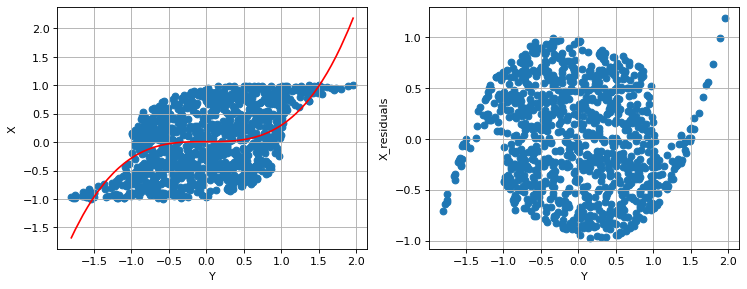



0.23583224405653566 0.6512297169839689
X, Eps are Independent: True
3.499957859761256 0.627005734096258
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Laplace')
Function: Cubic


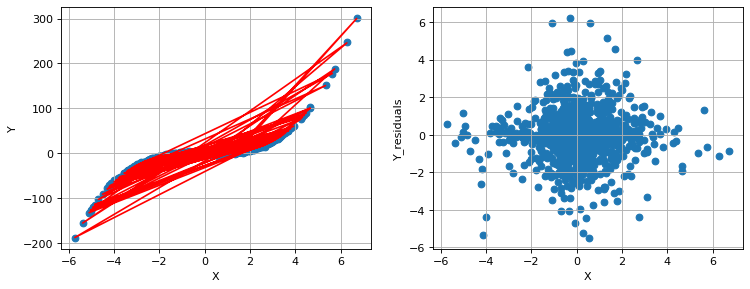

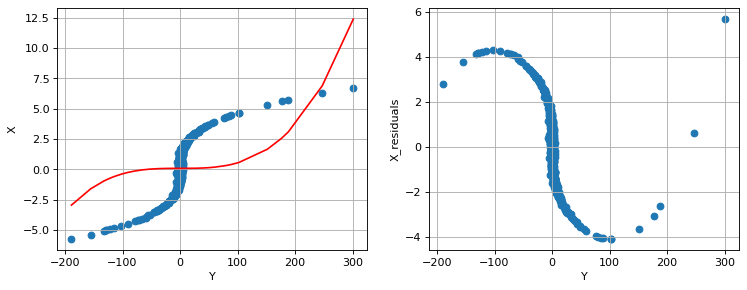



0.25120877047482587 0.5352410659820728
X, Eps are Independent: True
31.172230455931032 0.6141842894697795
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Gaussian')
Function: Quadratic


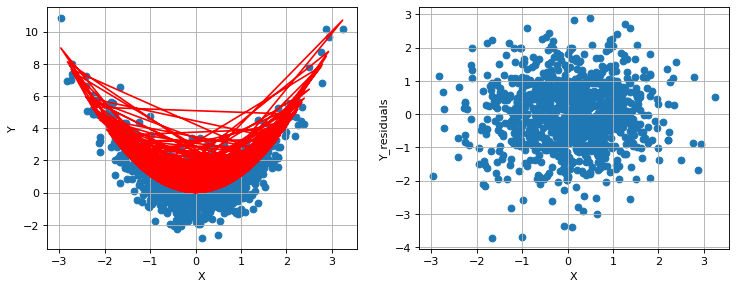

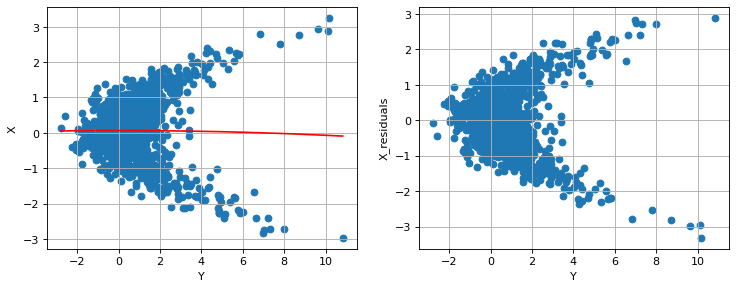



0.16534091109569846 0.5763559900640933
X, Eps are Independent: True
13.361844682693805 0.6060826602269758
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Uniform')
Function: Quadratic


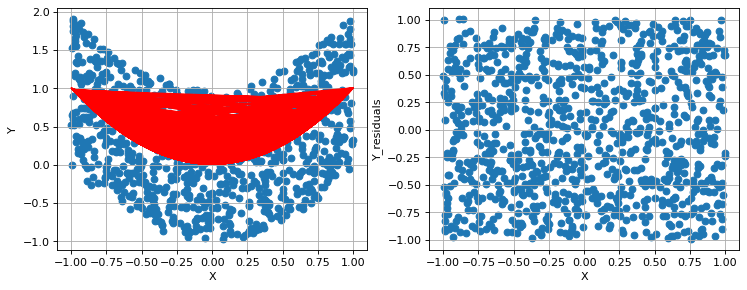

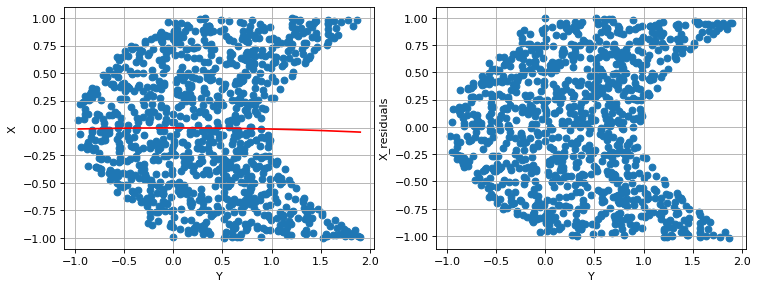



0.18430236900101699 0.6608728351916123
X, Eps are Independent: True
5.559334104068328 0.6473810531871631
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Laplace')
Function: Quadratic


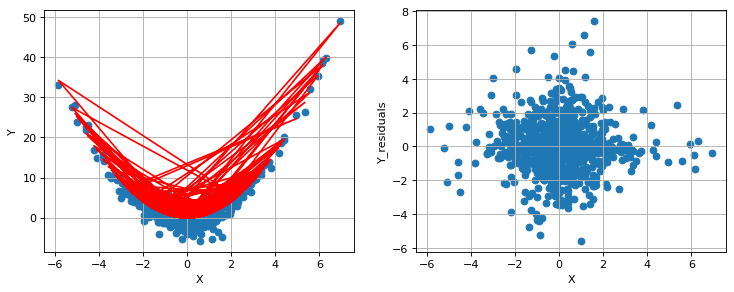

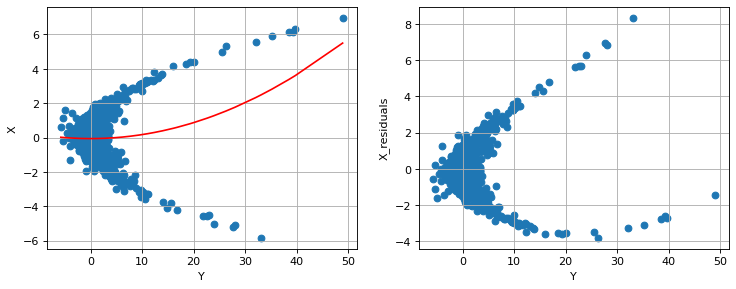



0.44435398507279894 0.5363392531431452
X, Eps are Independent: True
23.112562119688352 0.6133416221549977
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Gaussian')
Function: Sinus


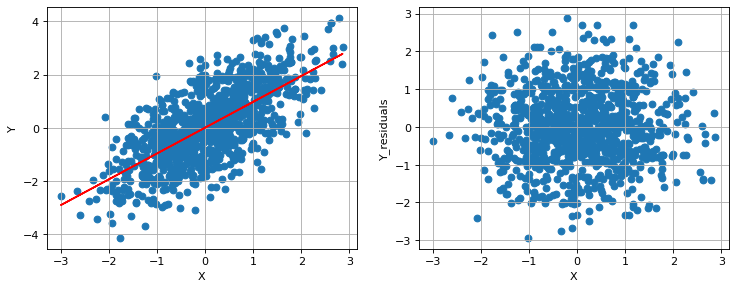

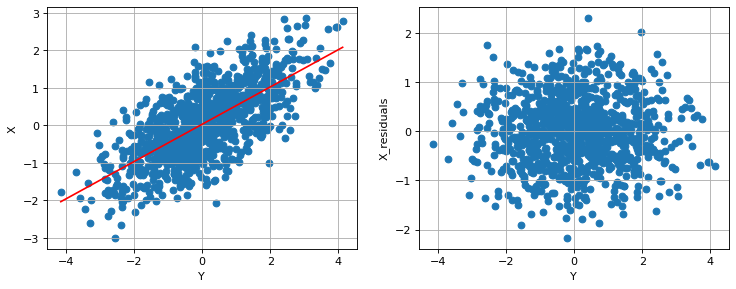



0.19685736909817186 0.5853811845568211
X, Eps are Independent: True
0.32969411182399283 0.5849844914361578
Y, Eps are Independent: True







Distribution: (X,Epsilon) ~ ('Uniform', 'Uniform')
Function: Sinus


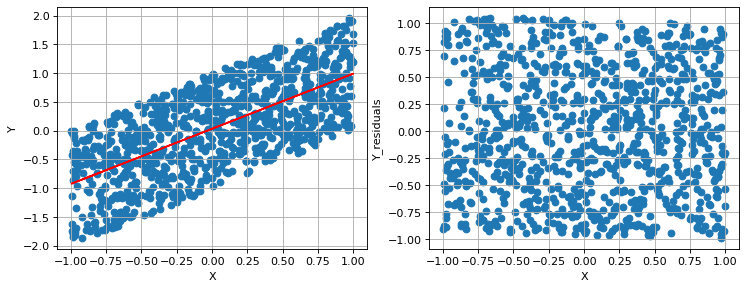

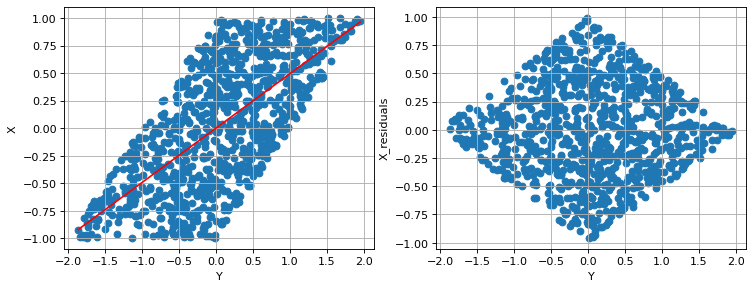



0.4961901617158781 0.6480206980932827
X, Eps are Independent: True
6.791840156022314 0.5931776760490046
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Laplace')
Function: Sinus


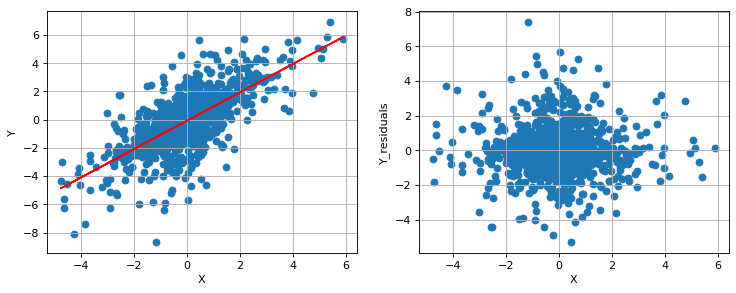

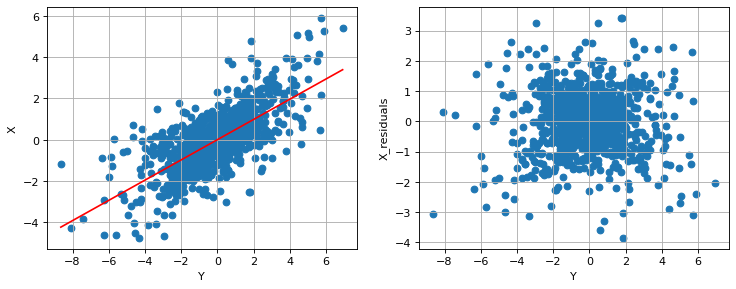



0.33521559279829327 0.5364157607270508
X, Eps are Independent: True
4.392256503689789 0.5712455727669467
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Uniform')
Function: Linear


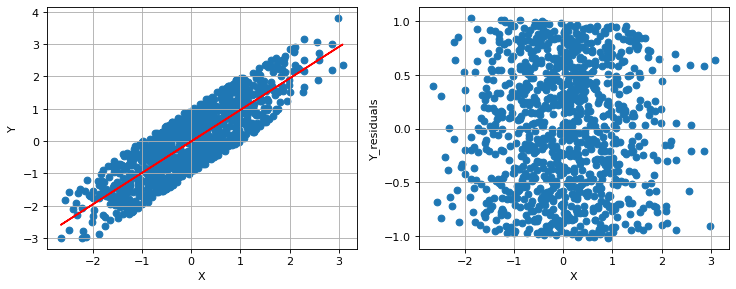

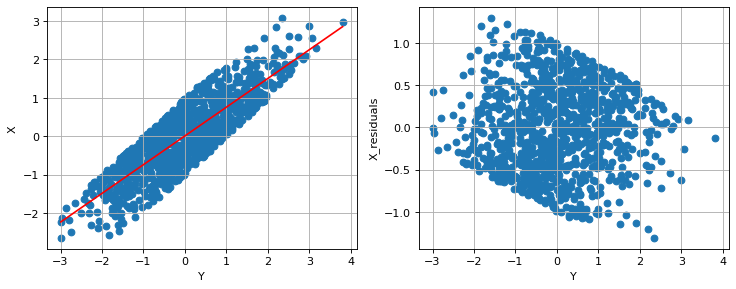



0.21823419209435627 0.6168851667896553
X, Eps are Independent: True
3.663554163645685 0.6004320015435776
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Laplace')
Function: Linear


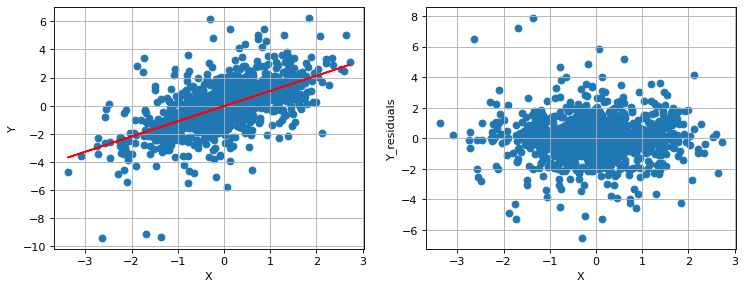

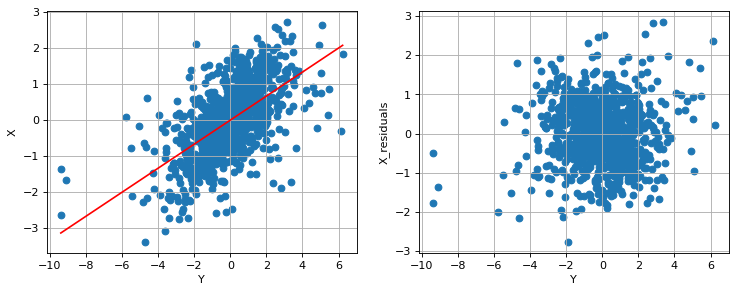



0.2424492819675762 0.5600409524536779
X, Eps are Independent: True
2.9494129122902843 0.5787430748711836
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Uniform')
Function: Cubic


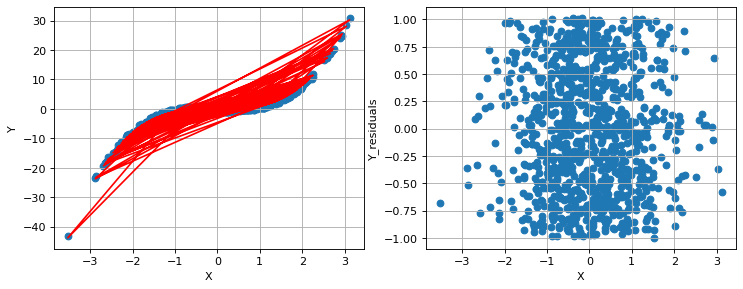

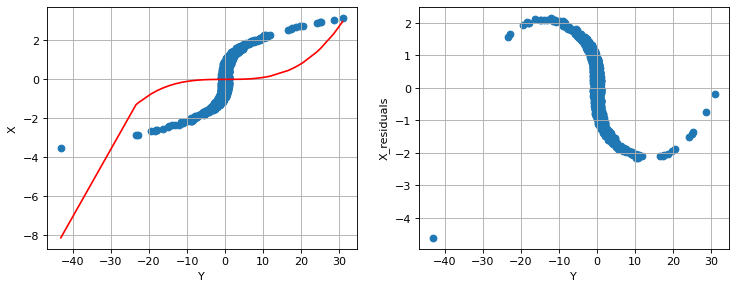



0.3682545416324497 0.6130887891312302
X, Eps are Independent: True
35.77054298062815 0.6464008593020848
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Laplace')
Function: Cubic


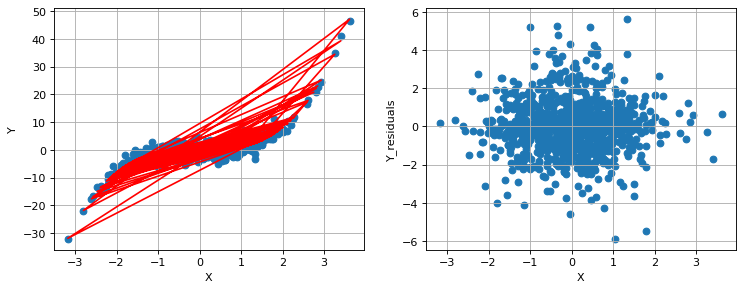

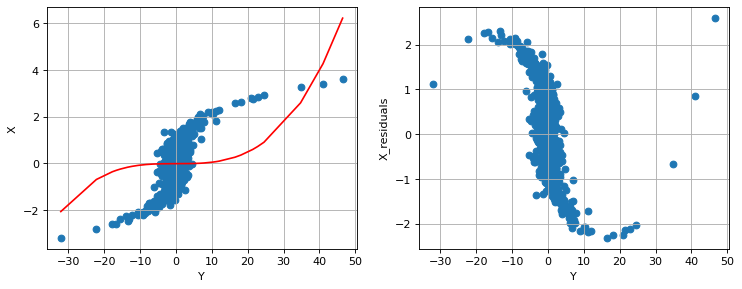



0.41374932442368445 0.5592512982156288
X, Eps are Independent: True
19.229653821773535 0.6185575448316202
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Uniform')
Function: Quadratic


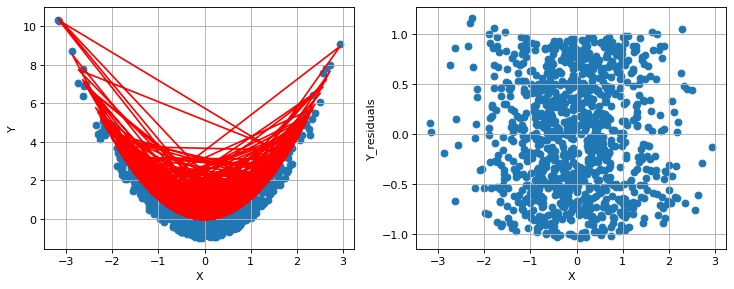

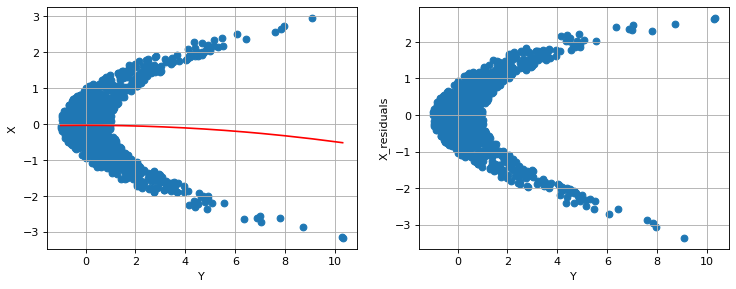



0.5039697985978068 0.6168546855881741
X, Eps are Independent: True
25.917877819893555 0.6441989301815889
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Laplace')
Function: Quadratic


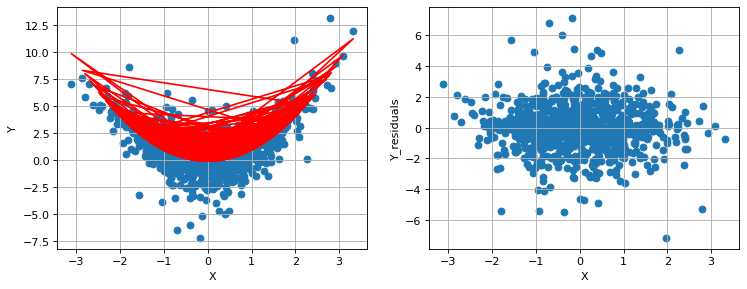

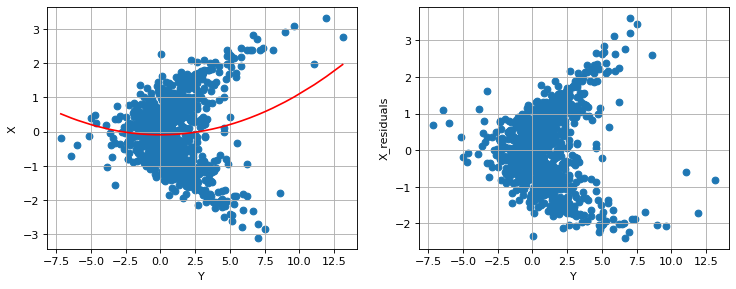



0.2701722925706662 0.5596708279704128
X, Eps are Independent: True
13.291365690825929 0.597239134740121
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Uniform')
Function: Sinus


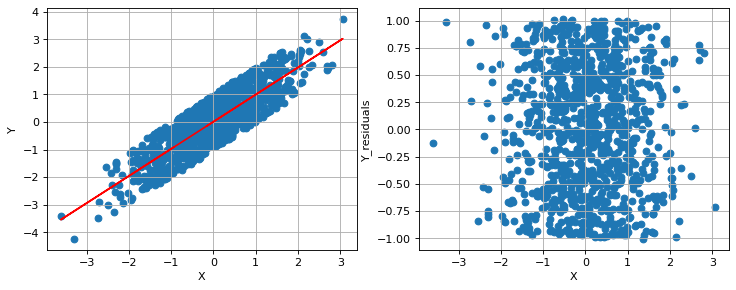

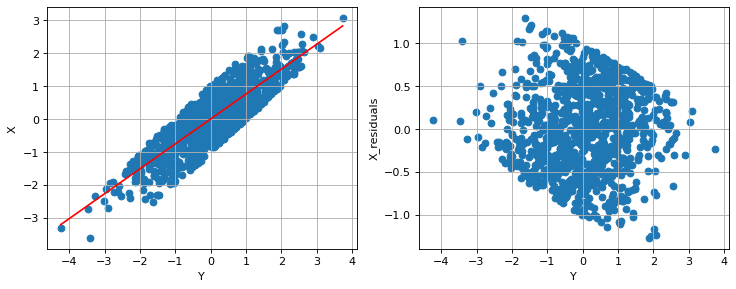



0.12536600599020373 0.6149460238984866
X, Eps are Independent: True
3.232749183568992 0.5947192463654002
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Gaussian', 'Laplace')
Function: Sinus


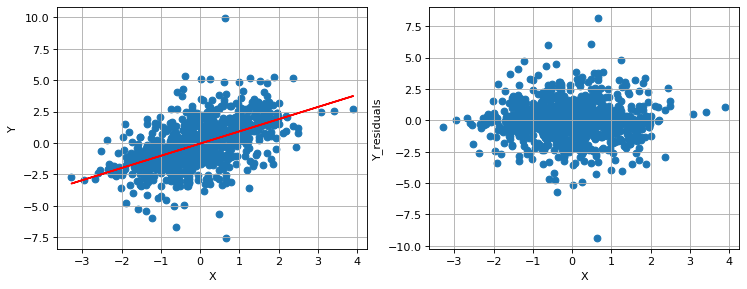

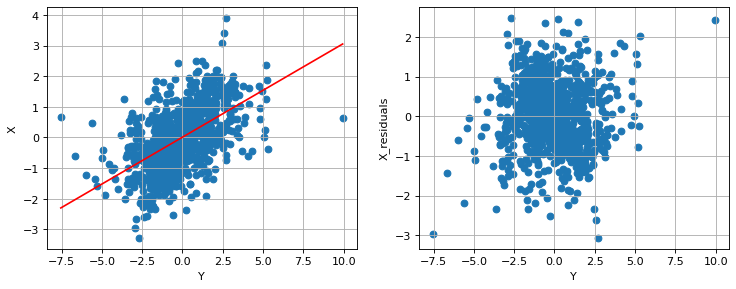



0.30803582468881757 0.5560114071198928
X, Eps are Independent: True
3.9512059003345827 0.5809385980574805
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Gaussian')
Function: Linear


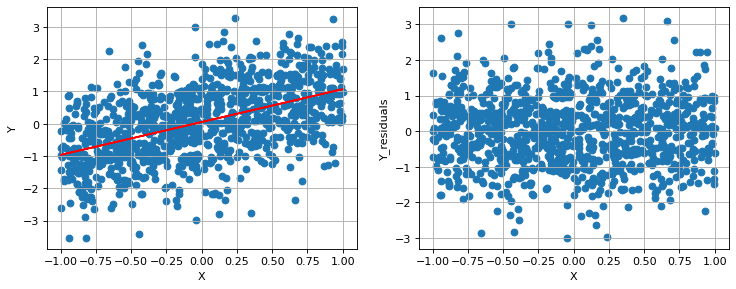

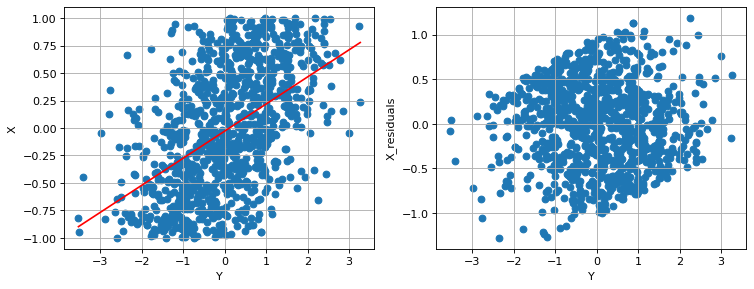



0.2724295864567238 0.6110423989767548
X, Eps are Independent: True
2.794220070213424 0.6009487241919258
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Laplace')
Function: Linear


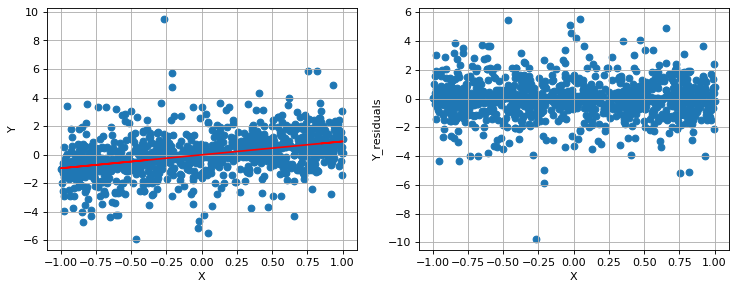

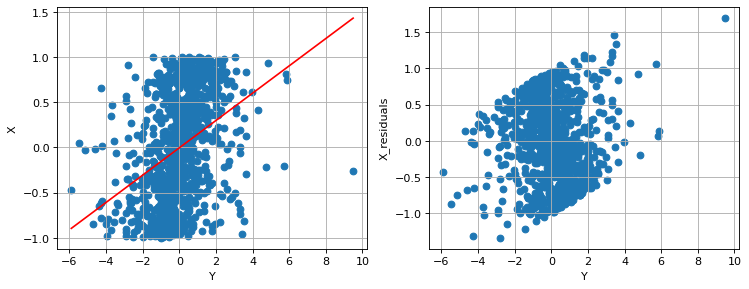



0.2812489093317908 0.5928726148337761
X, Eps are Independent: True
6.988393537917809 0.5937236008358535
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Gaussian')
Function: Cubic


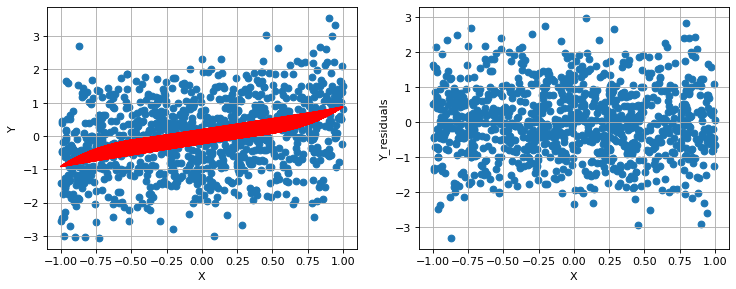

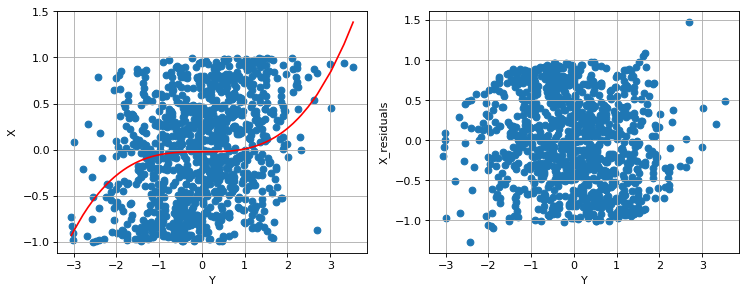



0.2983859902911236 0.6095422082614237
X, Eps are Independent: True
2.4903741197560274 0.6146951180461899
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Laplace')
Function: Cubic


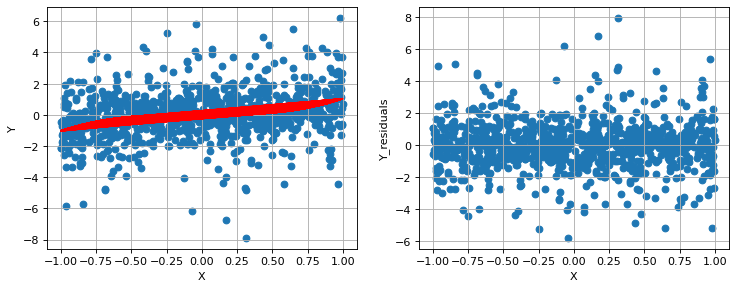

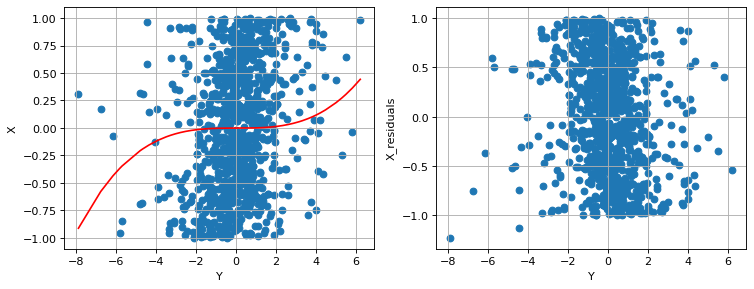



0.3291430087842319 0.5853890371551352
X, Eps are Independent: True
2.7517871701893517 0.5925419168580797
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Gaussian')
Function: Quadratic


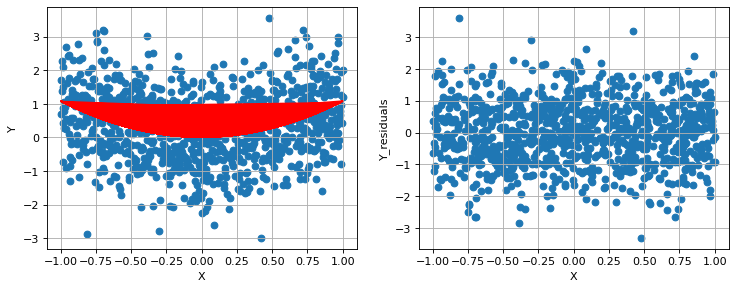

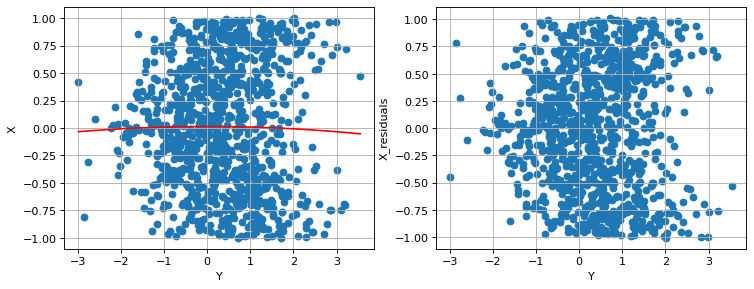



0.30276950281139026 0.6170054247573249
X, Eps are Independent: True
3.2285275571675505 0.6187075691708711
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Laplace')
Function: Quadratic


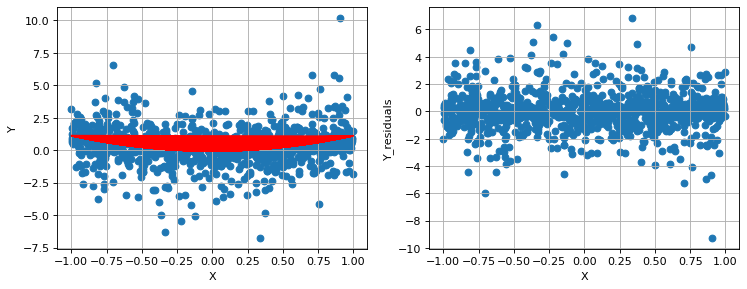

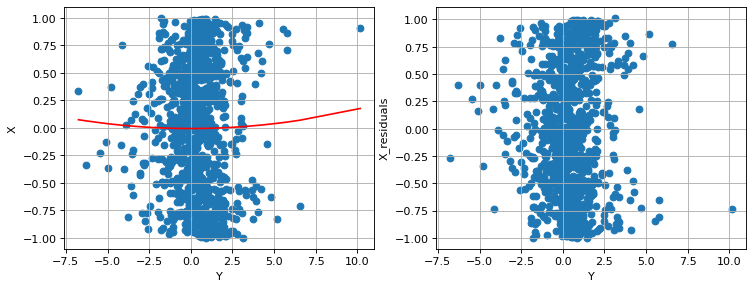



0.42407954905715134 0.5860640838756487
X, Eps are Independent: True
2.302114976379035 0.5895825534340589
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Gaussian')
Function: Sinus


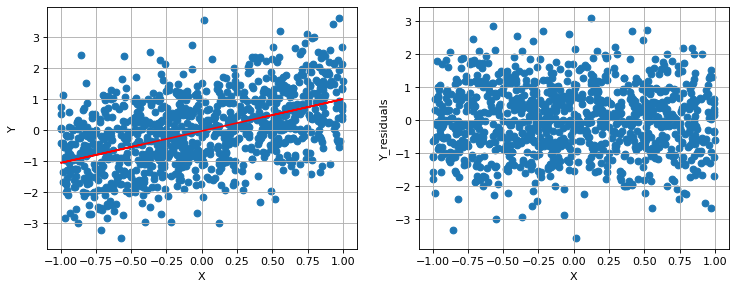

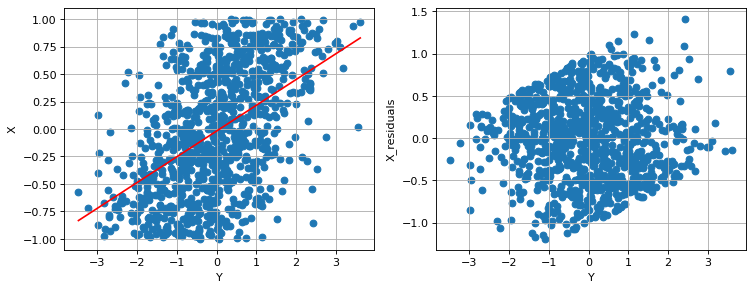



0.2610901717462683 0.6148453623669754
X, Eps are Independent: True
2.7727704344157775 0.5929230704396276
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Uniform', 'Laplace')
Function: Sinus


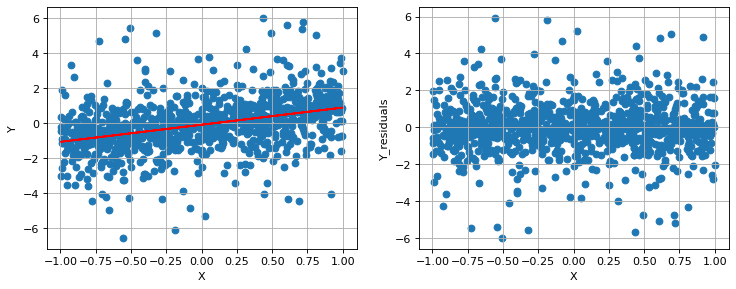

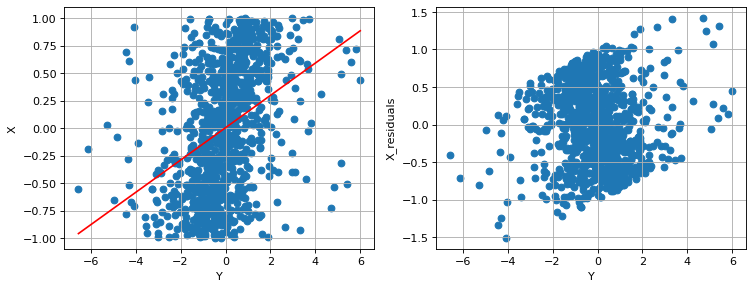



0.12978372492318016 0.5906457207747192
X, Eps are Independent: True
6.6947564878578945 0.5926574789660533
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Gaussian')
Function: Linear


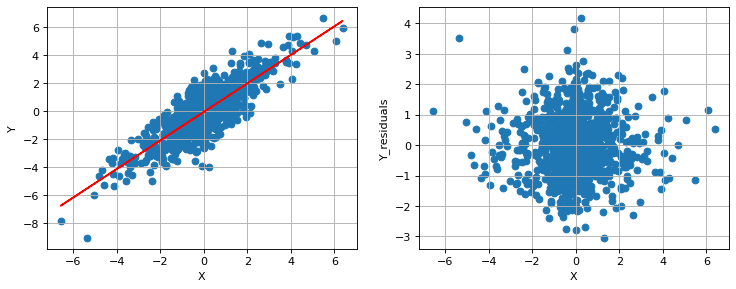

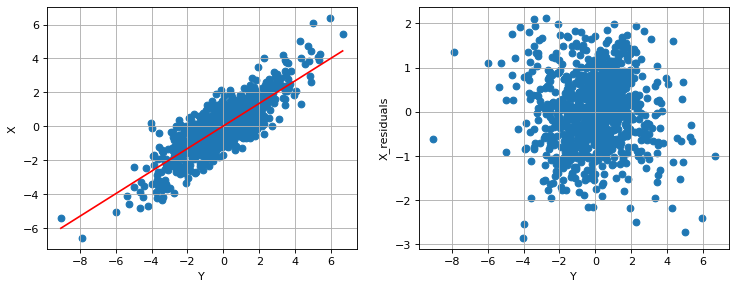



0.32629325324683517 0.5568273537644097
X, Eps are Independent: True
3.461897882802383 0.5752837910953014
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Uniform')
Function: Linear


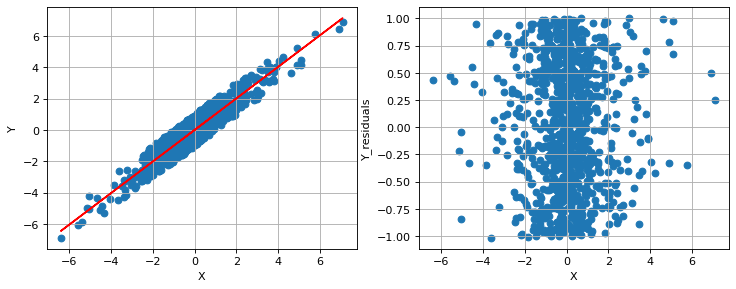

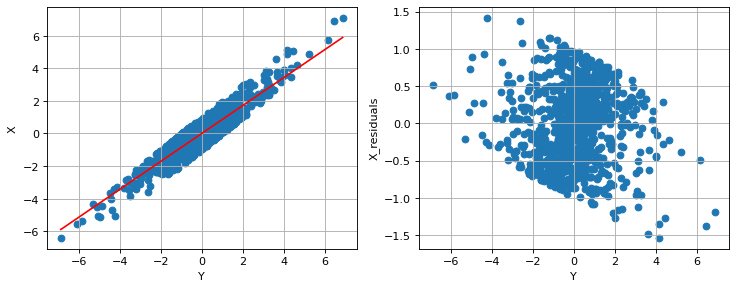



0.37680217257229726 0.5873410394934587
X, Eps are Independent: True
6.902324413672243 0.5918401504706088
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Gaussian')
Function: Cubic


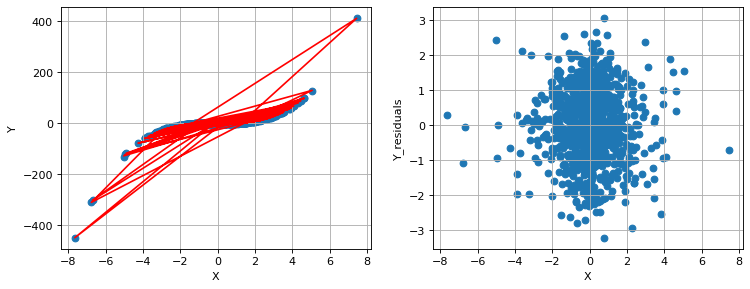

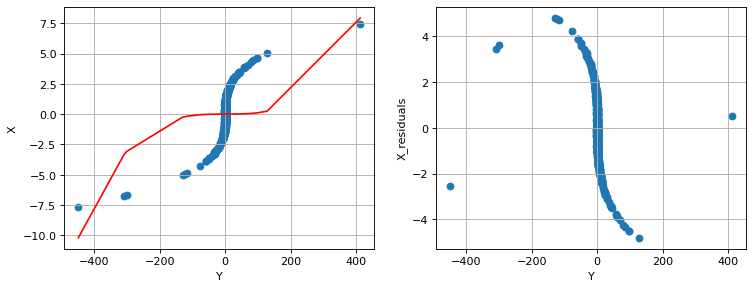



0.16563265325952897 0.5604100007816837
X, Eps are Independent: True
29.02725161722468 0.6225874478385335
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Uniform')
Function: Cubic


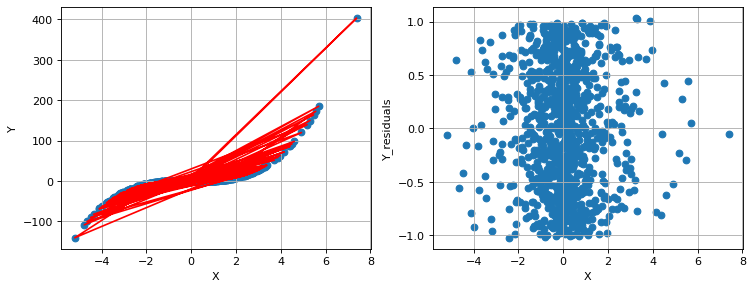

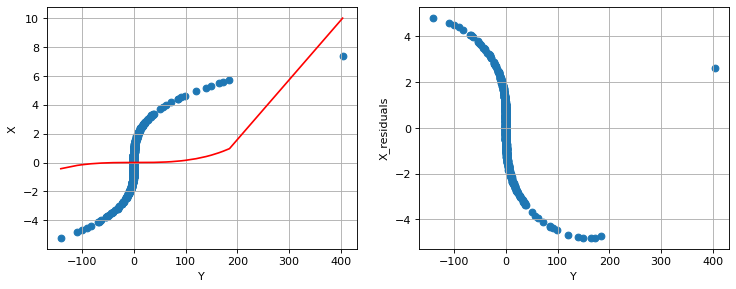



0.1545739925528334 0.5841957344361902
X, Eps are Independent: True
36.61649866649947 0.6134958106930058
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Gaussian')
Function: Quadratic


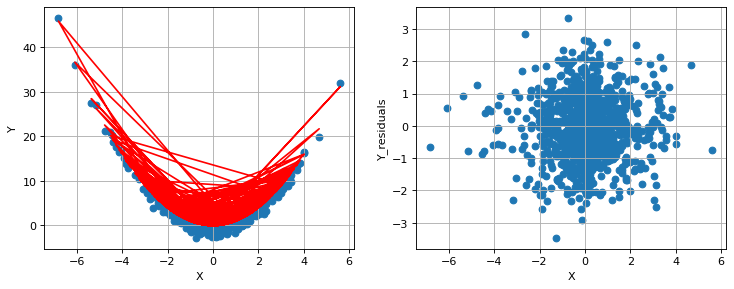

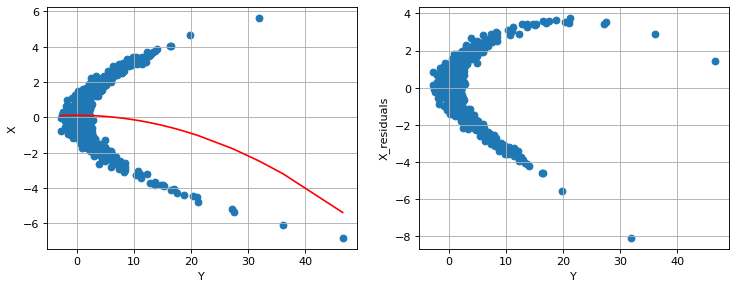



0.17098148022430715 0.5573151691265156
X, Eps are Independent: True
25.18018104890918 0.623856381780352
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Uniform')
Function: Quadratic


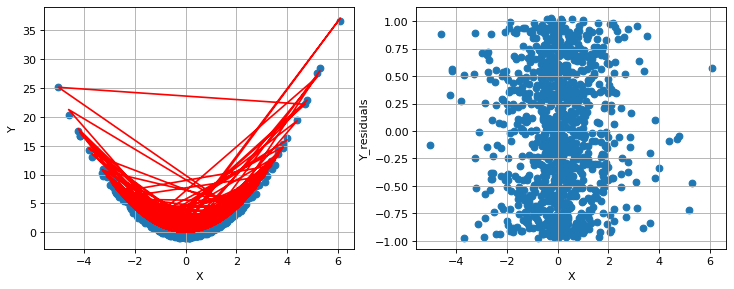

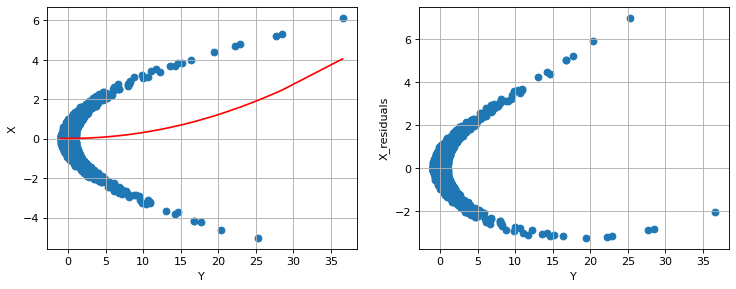



0.19501473814785417 0.5956688481972718
X, Eps are Independent: True
31.380782730167155 0.6409012700371155
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Gaussian')
Function: Sinus


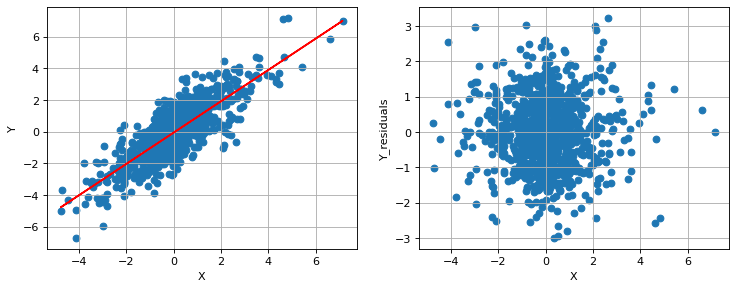

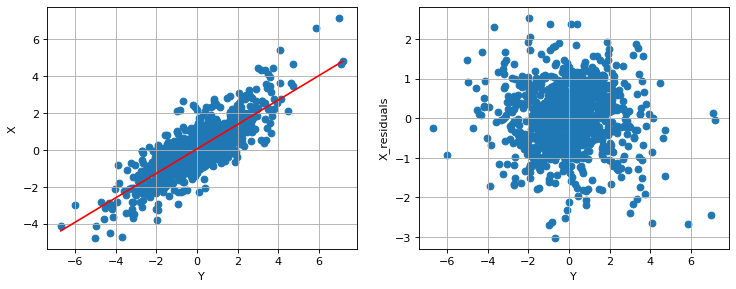



0.3069438442434925 0.5569734165040195
X, Eps are Independent: True
3.300210203624652 0.5771724387901322
Y, Eps are Independent: False







Distribution: (X,Epsilon) ~ ('Laplace', 'Uniform')
Function: Sinus


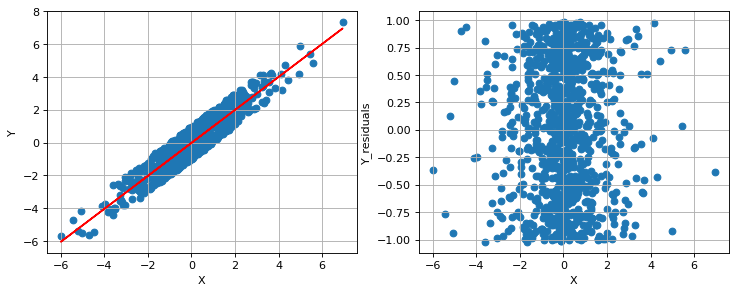

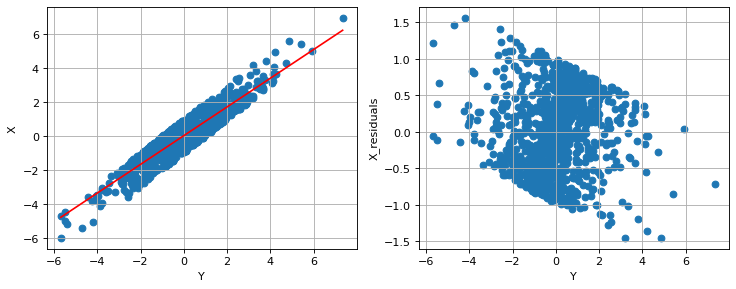



0.1932240522590893 0.5918831687229581
X, Eps are Independent: True
7.468914361438509 0.5938828472024468
Y, Eps are Independent: False









In [20]:
for func_dist in func_dists:
  reg_plotter(func_dist)
  reg_dep(func_dist)
  print("\n\n\n\n\n\n")

**Store unidentifiable cases:**

Prior to storing, I will do slight modifications to the `reg_dept` so as to omit the prints and also to instead of only find elements from the particular `regress_dict`, it takes as input a dictionary as well.



In [21]:
def reg_dep_pure(func_dist, dictt):
    x, x_transformed, eps, y, y_transformed, y_pred, x_pred = dictt[func_dist]    
    y_residuals = y_pred - y	
    testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
    x_residuals = x_pred - x
    testStat2, thresh2 = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
    return(testStat < thresh, testStat2 < thresh2)

Distribution: (X,Epsilon) ~ ('Gaussian', 'Gaussian')
Function: Linear


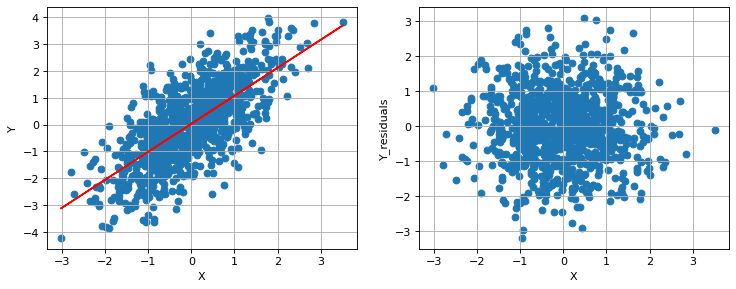

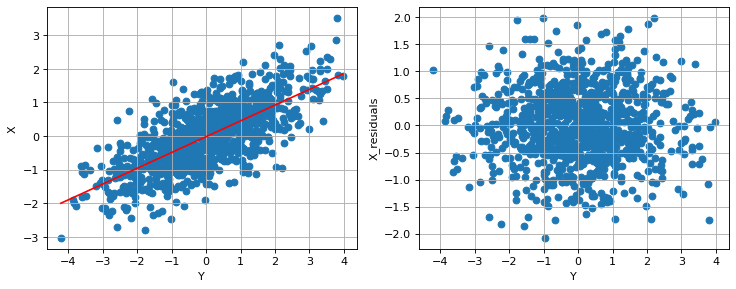

In [22]:
reg_plotter("LIN_GAU")


In [23]:
reg_dep_pure("LIN_GAU",regress_dict) #== (True,True)

(True, True)

Now I iterate over all cases in kesy of `regress_dict` and store cases that are unidentifiable in the `unid` list.



In [24]:
unid = []
for func_dist in tqdm(func_dists):
  if (reg_dep_pure(func_dist, regress_dict) == (True,True)):
    unid.append(func_dist)
   

100%|██████████| 36/36 [00:29<00:00,  1.20it/s]


In [25]:
unid

['LIN_GAU', 'SIN_GAU']

So, the only non-identifiable conditions were
1. Linear function with Gaussian distribution for both $X,\varepsilon$
2. Sinus function with Gaussian distribution for both $X,\varepsilon$

I created a range of 30 values between 0.01 and 30. I will oterate over this range, and in each iteration, I create `regress_dict_var`dictionary and build regression models with variance as the number we are iterating over. Moreover, I create another nested loop in which I iterate over all dictionary and store unidentifiable cases for the particular variance we are iterating in the outer loop.

At the end, all variances that include non-identifiable case are stored in the `unid_var` dictionary, in which keys are variances and values of non-identifiable cases.


In [26]:
start = 0.01
stop = 100
count = 30

eps_range = np.linspace(start=start, stop=stop, num=count)



In [27]:
eps_range

array([1.00000000e-02, 3.45793103e+00, 6.90586207e+00, 1.03537931e+01,
       1.38017241e+01, 1.72496552e+01, 2.06975862e+01, 2.41455172e+01,
       2.75934483e+01, 3.10413793e+01, 3.44893103e+01, 3.79372414e+01,
       4.13851724e+01, 4.48331034e+01, 4.82810345e+01, 5.17289655e+01,
       5.51768966e+01, 5.86248276e+01, 6.20727586e+01, 6.55206897e+01,
       6.89686207e+01, 7.24165517e+01, 7.58644828e+01, 7.93124138e+01,
       8.27603448e+01, 8.62082759e+01, 8.96562069e+01, 9.31041379e+01,
       9.65520690e+01, 1.00000000e+02])

In [28]:
unid_var = {var: [] for var in eps_range}


for i in tqdm(eps_range):

  mean = 0
  var = 1
  size = (1000, 1)
  regressor=None
  normal = np.random.normal
  uniform = np.random.uniform
  laplace = np.random.laplace
  regress_dict_var = {
      "LIN_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="l", regressor=regressor),
      "LIN_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="l", regressor=regressor),
      "LIN_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="l", regressor=regressor),
      "CUBIC_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="c", regressor=regressor),
      "CUBIC_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="c", regressor=regressor),
      "CUBIC_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="c", regressor=regressor),
      "QUAD_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="q", regressor=regressor),
      "QUAD_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="q", regressor=regressor),
      "QUAD_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="q", regressor=regressor),
      "SIN_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="s", regressor=regressor),
      "SIN_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="s", regressor=regressor),
      "SIN_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="s", regressor=regressor),

      "LIN_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="l", regressor=regressor),
      "LIN_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="l", regressor=regressor),
      "CUBIC_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="c", regressor=regressor),
      "CUBIC_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="c", regressor=regressor),
      "QUAD_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="q", regressor=regressor),
      "QUAD_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="q", regressor=regressor),
      "SIN_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="s", regressor=regressor),
      "SIN_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="s", regressor=regressor),


      "LIN_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="l", regressor=regressor),
      "LIN_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="l", regressor=regressor),
      "CUBIC_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="c", regressor=regressor),
      "CUBIC_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="c", regressor=regressor),
      "QUAD_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="q", regressor=regressor),
      "QUAD_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="q", regressor=regressor),
      "SIN_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="s", regressor=regressor),
      "SIN_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="s", regressor=regressor),


      "LIN_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="l", regressor=regressor),
      "LIN_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="l", regressor=regressor),
      "CUBIC_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="c", regressor=regressor),
      "CUBIC_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="c", regressor=regressor),
      "QUAD_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="q", regressor=regressor),
      "QUAD_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="q", regressor=regressor),
      "SIN_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="s", regressor=regressor),
      "SIN_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="s", regressor=regressor)
  }
  func_dist_vars = list(regress_dict_var.keys())


  for func_dist in func_dist_vars:
    if (reg_dep_pure(func_dist, regress_dict_var) == (True,True)):
      #unid_var.append([i,func_dist])
      unid_var[i].append(func_dist)
   


100%|██████████| 30/30 [15:11<00:00, 30.37s/it]


In [29]:
unid_var

{0.01: ['LIN_GAU',
  'LIN_UNI',
  'LIN_LAP',
  'SIN_GAU',
  'SIN_UNI',
  'SIN_LAP',
  'LIN_GAUxUNI',
  'LIN_GAUxLAP',
  'SIN_GAUxUNI',
  'LIN_UNIxGAU',
  'LIN_UNIxLAP',
  'SIN_UNIxGAU',
  'SIN_UNIxLAP',
  'LIN_LAPxGAU',
  'LIN_LAPxUNI',
  'SIN_LAPxGAU',
  'SIN_LAPxUNI'],
 3.4579310344827583: ['LIN_GAU',
  'SIN_GAU',
  'LIN_GAUxLAP',
  'LIN_UNIxGAU',
  'CUBIC_UNIxGAU',
  'QUAD_UNIxGAU',
  'SIN_UNIxGAU'],
 6.905862068965517: ['LIN_GAU',
  'CUBIC_UNI',
  'QUAD_UNI',
  'SIN_GAU',
  'LIN_GAUxLAP',
  'LIN_UNIxGAU',
  'LIN_UNIxLAP',
  'CUBIC_UNIxGAU',
  'QUAD_UNIxGAU',
  'QUAD_UNIxLAP',
  'SIN_UNIxGAU',
  'SIN_UNIxLAP'],
 10.353793103448275: ['LIN_GAU',
  'LIN_LAP',
  'CUBIC_UNI',
  'QUAD_UNI',
  'SIN_GAU',
  'SIN_UNI',
  'SIN_LAP',
  'LIN_GAUxUNI',
  'LIN_GAUxLAP',
  'SIN_GAUxUNI',
  'SIN_GAUxLAP',
  'LIN_UNIxGAU',
  'LIN_UNIxLAP',
  'CUBIC_UNIxGAU',
  'CUBIC_UNIxLAP',
  'QUAD_UNIxGAU',
  'QUAD_UNIxLAP',
  'SIN_UNIxGAU',
  'SIN_UNIxLAP',
  'SIN_LAPxGAU'],
 13.801724137931034: ['LIN_GAU',
  '

In [43]:
l = [key for key in list(unid_var.keys()) if len(unid_var[key])!=0]

[0.01,
 3.4579310344827583,
 6.905862068965517,
 10.353793103448275,
 13.801724137931034,
 17.249655172413792,
 20.697586206896553,
 24.145517241379313,
 27.59344827586207,
 31.041379310344826,
 34.48931034482758,
 37.93724137931034,
 41.3851724137931,
 44.83310344827586,
 48.28103448275862,
 51.72896551724138,
 55.176896551724134,
 58.62482758620689,
 62.07275862068965,
 65.52068965517242,
 68.96862068965517,
 72.41655172413793,
 75.8644827586207,
 79.31241379310345,
 82.76034482758621,
 86.20827586206897,
 89.65620689655172,
 93.10413793103449,
 96.55206896551725,
 100.0]

In [45]:
set(eps_range) - set(l) 

set()

There was no variance that would lead to unidentifiability for all combinations. But what we realize that the more variance increases, the more number of unidentifiable cases increase.

#### 3.2

# Post-Additive models

## Exercise 4

1. Perform the same test as in Excercise 3 for the following model: $Y=(f(X)+\epsilon)^3$, where the corresponding function $f(X)$ is specified [here](https://docs.google.com/spreadsheets/d/1aS87yTukUsMIJcLMMaeuVKnzVLkhhU7m3wKfNyN2I6E/edit?usp=sharing). 
2. What are your conclusions from all exercises in this notebook?

Similar to previous parts, I write a general function `regress_pa` that take three possible functions of quadartic, cubic, and sinus, and then create a dictionary in whichs its values apply the particular post-additive model specified in the Exercise 4 to its key. Again, keys of the dictionary form all possible combinations of functions and distributions.

### My Solution


#### 4

In [31]:
## 
def regress_pa(x_mean, x_var, eps_mean, eps_var, size, x_dist, eps_dist, func="l", regressor=None):
    x = x_dist(x_mean, x_var, size=size)
    eps = eps_dist(eps_mean, eps_var, size=size)
    x_transformed = x.copy()
    # cubic function
    if func == "c":
        f_transformed = (x + eps)**3
    # quadratic function
    elif func == "q":
        x_transformed = (x + eps)**2
    # sinus functions    
    elif func == "s":
        x_transformed == np.sin(x + eps)
    # regress on either x (in linear case, as x remains intact), or if nonlinear on transformed x

    y = x_transformed + eps
    regressor = LinearRegression()
    regressor.fit(x_transformed.reshape(-1, 1),y)
    y_pred = regressor.predict(x_transformed.reshape(-1, 1))

    #testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)

    y_transformed = y.copy()
    # cubic function
    if func == "c":
        y_transformed = (y + eps)**3
    # quadratic function
    elif func == "q":
        y_transformed = (y + eps)**2
    # sinus functions    
    elif func == "s":
        y_transformed == np.sin(y + eps)


    regressor2 = LinearRegression()
    regressor2.fit(y_transformed.reshape(-1, 1), x)
    x_pred = regressor2.predict(y_transformed.reshape(-1, 1))
    #testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
    return x, x_transformed, eps, y, y_transformed, y_pred, x_pred

In [32]:

mean = 0
var = 1
i=1
size = (1000, 1)
regressor=None
normal = np.random.normal
uniform = np.random.uniform
laplace = np.random.laplace

regress_dict_pa = {
    "LIN_GAU": regress_pa(mean, var, mean, var*i, size, normal, normal, func="l", regressor=regressor),
    "LIN_UNI": regress_pa(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="l", regressor=regressor),
    "LIN_LAP": regress_pa(mean, var, mean, var*i, size, laplace, laplace, func="l", regressor=regressor),
    "CUBIC_GAU": regress_pa(mean, var, mean, var*i, size, normal, normal, func="c", regressor=regressor),
    "CUBIC_UNI": regress_pa(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="c", regressor=regressor),
    "CUBIC_LAP": regress_pa(mean, var, mean, var*i, size, laplace, laplace, func="c", regressor=regressor),
    "QUAD_GAU": regress_pa(mean, var, mean, var*i, size, normal, normal, func="q", regressor=regressor),
    "QUAD_UNI": regress_pa(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="q", regressor=regressor),
    "QUAD_LAP": regress_pa(mean, var, mean, var*i, size, laplace, laplace, func="q", regressor=regressor),
    "SIN_GAU": regress_pa(mean, var, mean, var*i, size, normal, normal, func="s", regressor=regressor),
    "SIN_UNI": regress_pa(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="s", regressor=regressor),
    "SIN_LAP": regress_pa(mean, var, mean, var*i, size, laplace, laplace, func="s", regressor=regressor),

    "LIN_GAUxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="l", regressor=regressor),
    "LIN_GAUxLAP": regress_pa(mean, var, mean, var*i, size, normal, laplace, func="l", regressor=regressor),
    "CUBIC_GAUxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="c", regressor=regressor),
    "CUBIC_GAUxLAP": regress_pa(mean, var, mean, var*i, size, normal, laplace, func="c", regressor=regressor),
    "QUAD_GAUxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="q", regressor=regressor),
    "QUAD_GAUxLAP": regress_pa(mean, var, mean, var*i, size, normal, laplace, func="q", regressor=regressor),
    "SIN_GAUxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="s", regressor=regressor),
    "SIN_GAUxLAP": regress_pa(mean, var, mean, var*i, size, normal, laplace, func="s", regressor=regressor),


    "LIN_UNIxGAU": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, normal, func="l", regressor=regressor),
    "LIN_UNIxLAP": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="l", regressor=regressor),
    "CUBIC_UNIxGAU": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, normal, func="c", regressor=regressor),
    "CUBIC_UNIxLAP": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="c", regressor=regressor),
    "QUAD_UNIxGAU": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, normal, func="q", regressor=regressor),
    "QUAD_UNIxLAP": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="q", regressor=regressor),
    "SIN_UNIxGAU": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, normal, func="s", regressor=regressor),
    "SIN_UNIxLAP": regress_pa(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="s", regressor=regressor),


    "LIN_LAPxGAU": regress_pa(mean, var, mean, var*i, size, laplace, normal, func="l", regressor=regressor),
    "LIN_LAPxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="l", regressor=regressor),
    "CUBIC_LAPxGAU": regress_pa(mean, var, mean, var*i, size, laplace, normal, func="c", regressor=regressor),
    "CUBIC_LAPxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="c", regressor=regressor),
    "QUAD_LAPxGAU": regress_pa(mean, var, mean, var*i, size, laplace, normal, func="q", regressor=regressor),
    "QUAD_LAPxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="q", regressor=regressor),
    "SIN_LAPxGAU": regress_pa(mean, var, mean, var*i, size, laplace, normal, func="s", regressor=regressor),
    "SIN_LAPxUNI": regress_pa(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="s", regressor=regressor)
}


In [33]:
func_dist_pa = list(regress_dict_pa.keys())

In [34]:
unid_pa = []
for func_dist in tqdm(func_dist_pa):
  if (reg_dep_pure(func_dist, regress_dict_pa) == (True,True)):
    unid_pa.append(func_dist)
   

100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


In [35]:
unid_pa

['LIN_GAU', 'SIN_GAU']

Interesting! The results of additive noise model and post-additive noise model were the same...